# Day 3: Lasso Regression (L1 Regularization) for Feature Selection

## 🎯 Learning Objectives
- Understand L1 regularization and sparsity
- Automatic feature selection in trading
- Compare Lasso vs Ridge behavior
- Build interpretable trading models

---

## 📚 Theory: Lasso Regression

### The L1 Penalty
$$\hat{\beta}_{lasso} = \arg\min_\beta \left[ \sum_{i=1}^n (y_i - x_i^T\beta)^2 + \lambda\sum_{j=1}^p |\beta_j| \right]$$

### Why Lasso Creates Sparsity
- L1 penalty has corners at zero
- Optimization tends to hit corners
- Coefficients are exactly zero (not just small)

### Geometric Interpretation
- **Ridge**: Circular constraint → coefficients shrink uniformly
- **Lasso**: Diamond constraint → coefficients hit zero

### Pros & Cons

| Pros | Cons |
|------|------|
| Automatic feature selection | Unstable with correlated features |
| Sparse, interpretable models | Selects only 1 from correlated group |
| Handles p > n | No closed-form solution |
| Reduces model complexity | May under-select features |

---

In [1]:
import numpy as np
import pandas as pd
import yfinance as yf
from datetime import datetime, timedelta
import matplotlib.pyplot as plt
import warnings
from sklearn.linear_model import Lasso, LassoCV, Ridge, LinearRegression
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
import seaborn as sns

warnings.filterwarnings('ignore')
plt.style.use('seaborn-v0_8-whitegrid')

TRADING_DAYS = 252
RISK_FREE_RATE = 0.05

# Download data
tickers = ['AAPL', 'MSFT', 'GOOGL', 'AMZN', 'META', 'NVDA', 'JPM', 'GS', 'BAC', 'SPY', 'QQQ', 'XLF', 'XLK']
end_date = datetime.now()
start_date = end_date - timedelta(days=5*365)

print("📥 Downloading data...")
data = yf.download(tickers, start=start_date, end=end_date, progress=False, auto_adjust=True)
prices = data['Close'].dropna()
returns = prices.pct_change().dropna()

print(f"✅ Data: {len(returns)} days, {len(tickers)} assets")

📥 Downloading data...
✅ Data: 1255 days, 13 assets


In [2]:
# Create MANY features (some useful, some noise)
target_stock = 'AAPL'
df = pd.DataFrame(index=returns.index)

# Momentum features (various lookbacks)
for lag in [1, 2, 3, 5, 10, 15, 20, 30, 60]:
    df[f'momentum_{lag}d'] = prices[target_stock].pct_change(lag)

# Volatility features
for window in [5, 10, 20, 30, 60]:
    df[f'volatility_{window}d'] = returns[target_stock].rolling(window).std()

# MA crossover signals
for fast, slow in [(5, 20), (10, 50), (20, 100)]:
    ma_fast = prices[target_stock].rolling(fast).mean()
    ma_slow = prices[target_stock].rolling(slow).mean()
    df[f'ma_cross_{fast}_{slow}'] = (ma_fast - ma_slow) / ma_slow

# Cross-asset features
for ticker in tickers:
    if ticker != target_stock:
        df[f'{ticker}_return'] = returns[ticker]
        df[f'{ticker}_mom_5d'] = prices[ticker].pct_change(5)

# Volume features
if 'Volume' in data.columns.get_level_values(0):
    vol = data['Volume'][target_stock]
    df['volume_ratio'] = vol / vol.rolling(20).mean()
    df['volume_change'] = vol.pct_change()

# Target
df['target'] = returns[target_stock].shift(-1)
df = df.dropna()

print(f"\n📊 Total Features: {len(df.columns)-1}")
print(f"📈 Samples: {len(df)}")


📊 Total Features: 43
📈 Samples: 1156


In [3]:
# Prepare data
feature_cols = [c for c in df.columns if c != 'target']
X = df[feature_cols]
y = df['target']

# Train/Test split
split_idx = int(len(df) * 0.8)
X_train, X_test = X.iloc[:split_idx], X.iloc[split_idx:]
y_train, y_test = y.iloc[:split_idx], y.iloc[split_idx:]

# Scale features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

print(f"Train: {len(X_train)}, Test: {len(X_test)}")
print(f"Features: {len(feature_cols)}")

Train: 924, Test: 232
Features: 43


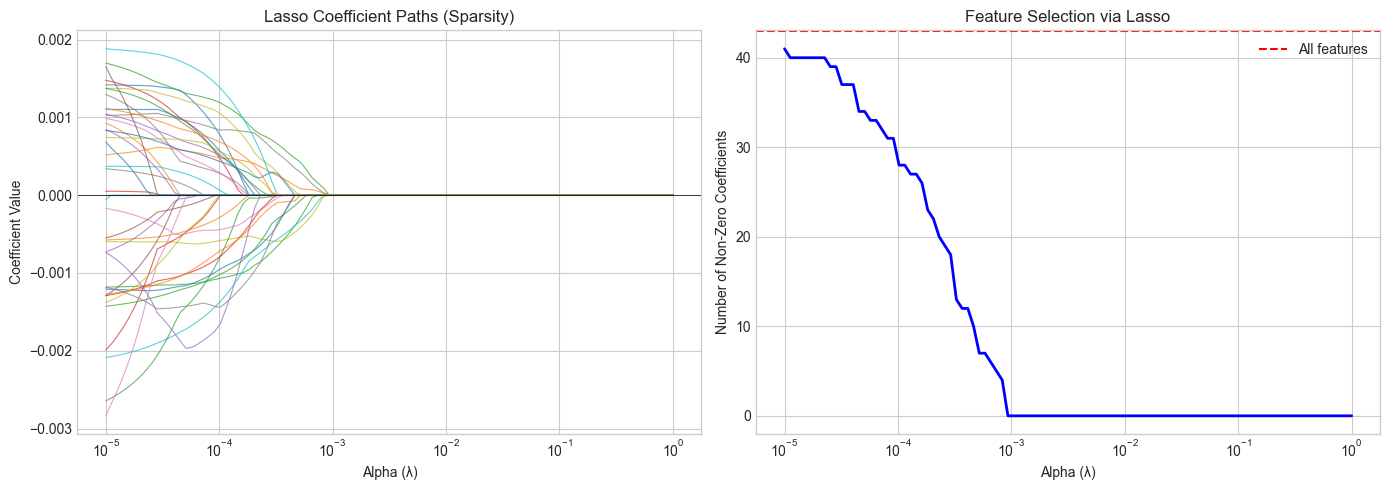

In [4]:
# Lasso Regularization Path
alphas = np.logspace(-5, 0, 100)
coef_paths = []
n_nonzero = []

for alpha in alphas:
    lasso = Lasso(alpha=alpha, max_iter=10000)
    lasso.fit(X_train_scaled, y_train)
    coef_paths.append(lasso.coef_)
    n_nonzero.append(np.sum(lasso.coef_ != 0))

coef_paths = np.array(coef_paths)

# Plot regularization path
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Coefficient paths
for i in range(coef_paths.shape[1]):
    axes[0].semilogx(alphas, coef_paths[:, i], linewidth=0.8, alpha=0.7)
axes[0].axhline(y=0, color='black', linestyle='-', linewidth=0.5)
axes[0].set_xlabel('Alpha (λ)')
axes[0].set_ylabel('Coefficient Value')
axes[0].set_title('Lasso Coefficient Paths (Sparsity)')

# Number of non-zero coefficients
axes[1].semilogx(alphas, n_nonzero, linewidth=2, color='blue')
axes[1].set_xlabel('Alpha (λ)')
axes[1].set_ylabel('Number of Non-Zero Coefficients')
axes[1].set_title('Feature Selection via Lasso')
axes[1].axhline(y=len(feature_cols), color='r', linestyle='--', label='All features')
axes[1].legend()

plt.tight_layout()
plt.show()

In [5]:
# Cross-validation for optimal alpha
tscv = TimeSeriesSplit(n_splits=5)
lasso_cv = LassoCV(alphas=np.logspace(-5, -1, 100), cv=tscv, max_iter=10000)
lasso_cv.fit(X_train_scaled, y_train)

optimal_alpha = lasso_cv.alpha_
print(f"\n✅ Optimal Alpha (via CV): {optimal_alpha:.6f}")
print(f"📊 Selected Features: {np.sum(lasso_cv.coef_ != 0)} / {len(feature_cols)}")


✅ Optimal Alpha (via CV): 0.100000
📊 Selected Features: 0 / 43


In [6]:
# Show selected features
selected_mask = lasso_cv.coef_ != 0
selected_features = np.array(feature_cols)[selected_mask]
selected_coefs = lasso_cv.coef_[selected_mask]

# Sort by absolute coefficient
sort_idx = np.argsort(np.abs(selected_coefs))[::-1]
selected_features = selected_features[sort_idx]
selected_coefs = selected_coefs[sort_idx]

print("\n" + "="*60)
print("LASSO SELECTED FEATURES (Ranked by Importance)")
print("="*60)
for i, (feat, coef) in enumerate(zip(selected_features[:15], selected_coefs[:15])):
    direction = "📈" if coef > 0 else "📉"
    print(f"{i+1:2d}. {feat:<30} {coef:>10.6f} {direction}")

if len(selected_features) > 15:
    print(f"... and {len(selected_features) - 15} more features")


LASSO SELECTED FEATURES (Ranked by Importance)


In [7]:
# Compare OLS, Ridge, and Lasso
# OLS
ols = LinearRegression()
ols.fit(X_train_scaled, y_train)
ols_pred = ols.predict(X_test_scaled)

# Ridge (using CV)
from sklearn.linear_model import RidgeCV
ridge_cv = RidgeCV(alphas=np.logspace(-3, 3, 100), cv=tscv)
ridge_cv.fit(X_train_scaled, y_train)
ridge_pred = ridge_cv.predict(X_test_scaled)

# Lasso
lasso_pred = lasso_cv.predict(X_test_scaled)

print("\n" + "="*70)
print("MODEL COMPARISON: OLS vs RIDGE vs LASSO")
print("="*70)

models = ['OLS', 'Ridge', 'Lasso']
preds = [ols_pred, ridge_pred, lasso_pred]
n_features = [len(feature_cols), len(feature_cols), np.sum(lasso_cv.coef_ != 0)]

print(f"\n{'Metric':<20} {'OLS':>12} {'Ridge':>12} {'Lasso':>12}")
print("-" * 60)
print(f"{'R² Score':<20} {r2_score(y_test, ols_pred):>12.4f} {r2_score(y_test, ridge_pred):>12.4f} {r2_score(y_test, lasso_pred):>12.4f}")
print(f"{'RMSE':<20} {np.sqrt(mean_squared_error(y_test, ols_pred)):>12.6f} {np.sqrt(mean_squared_error(y_test, ridge_pred)):>12.6f} {np.sqrt(mean_squared_error(y_test, lasso_pred)):>12.6f}")
print(f"{'Dir. Accuracy':<20} {(np.sign(ols_pred)==np.sign(y_test)).mean():>12.2%} {(np.sign(ridge_pred)==np.sign(y_test)).mean():>12.2%} {(np.sign(lasso_pred)==np.sign(y_test)).mean():>12.2%}")
print(f"{'# Features':<20} {n_features[0]:>12} {n_features[1]:>12} {n_features[2]:>12}")


MODEL COMPARISON: OLS vs RIDGE vs LASSO

Metric                        OLS        Ridge        Lasso
------------------------------------------------------------
R² Score                  -0.0198      -0.0100      -0.0008
RMSE                     0.020520     0.020421     0.020329
Dir. Accuracy              54.31%       51.29%       51.29%
# Features                     43           43            0


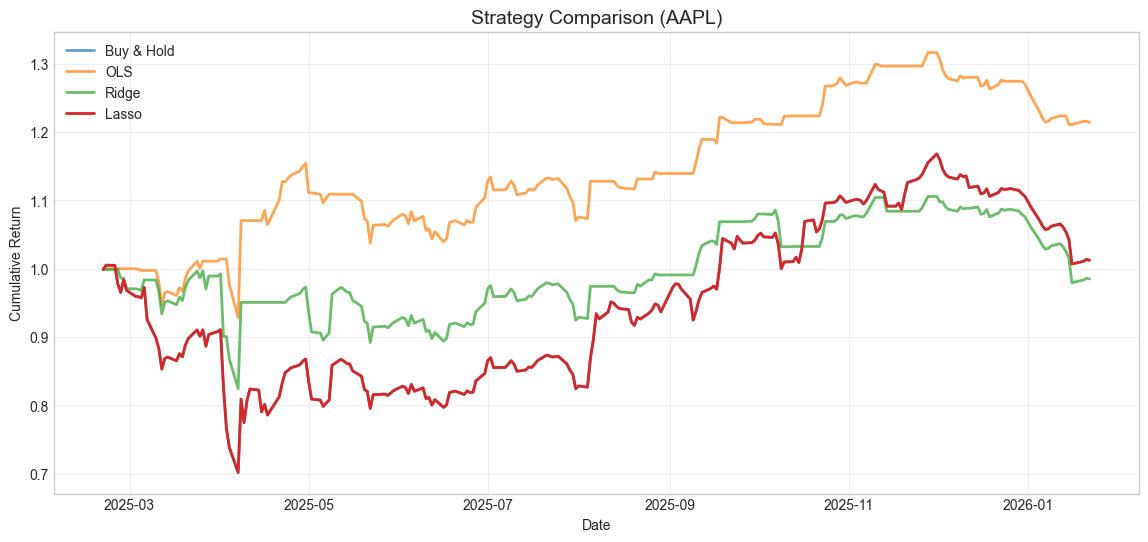

In [8]:
# Trading Strategy Comparison
backtest = pd.DataFrame(index=y_test.index)
backtest['actual'] = y_test.values

# Signals
for name, pred in zip(['ols', 'ridge', 'lasso'], preds):
    backtest[f'{name}_signal'] = np.where(pred > 0, 1, 0)
    backtest[f'{name}_return'] = backtest[f'{name}_signal'] * backtest['actual']
    backtest[f'{name}_cum'] = (1 + backtest[f'{name}_return']).cumprod()

backtest['buy_hold_cum'] = (1 + backtest['actual']).cumprod()

# Plot
plt.figure(figsize=(14, 6))
plt.plot(backtest.index, backtest['buy_hold_cum'], label='Buy & Hold', linewidth=2, alpha=0.7)
plt.plot(backtest.index, backtest['ols_cum'], label='OLS', linewidth=2, alpha=0.7)
plt.plot(backtest.index, backtest['ridge_cum'], label='Ridge', linewidth=2, alpha=0.7)
plt.plot(backtest.index, backtest['lasso_cum'], label='Lasso', linewidth=2)
plt.title(f'Strategy Comparison ({target_stock})', fontsize=14)
plt.xlabel('Date')
plt.ylabel('Cumulative Return')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

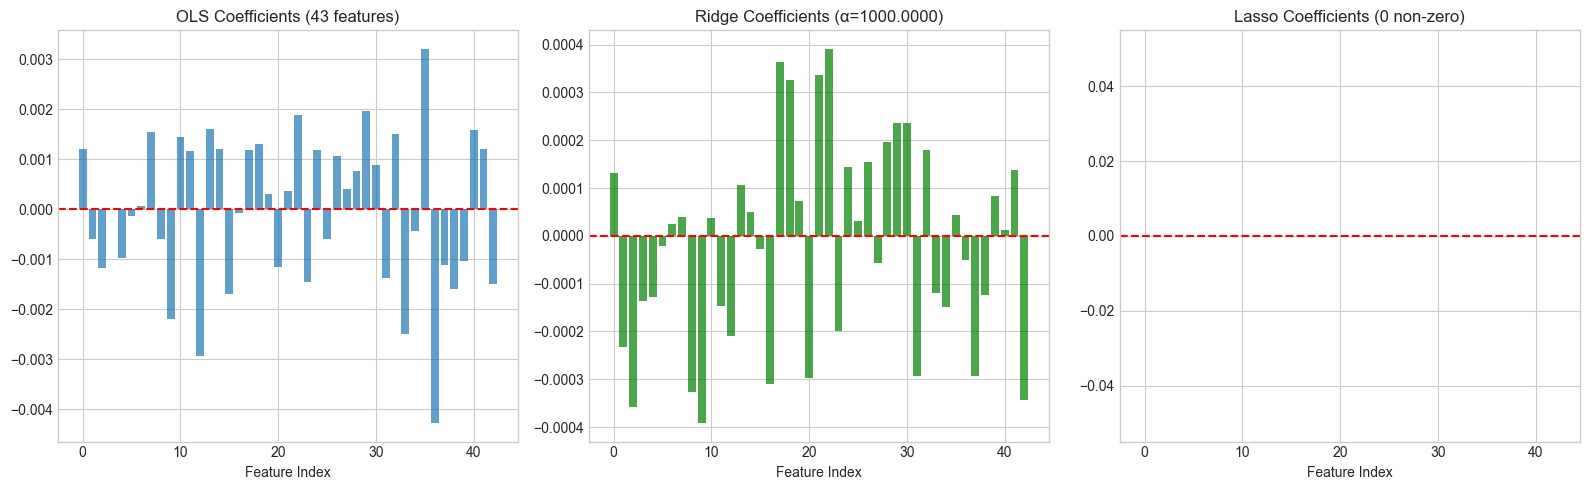

In [9]:
# Coefficient comparison visualization
fig, axes = plt.subplots(1, 3, figsize=(16, 5))

# OLS coefficients
axes[0].bar(range(len(ols.coef_)), ols.coef_, alpha=0.7)
axes[0].set_title(f'OLS Coefficients ({len(feature_cols)} features)')
axes[0].set_xlabel('Feature Index')
axes[0].axhline(y=0, color='r', linestyle='--')

# Ridge coefficients
axes[1].bar(range(len(ridge_cv.coef_)), ridge_cv.coef_, alpha=0.7, color='green')
axes[1].set_title(f'Ridge Coefficients (α={ridge_cv.alpha_:.4f})')
axes[1].set_xlabel('Feature Index')
axes[1].axhline(y=0, color='r', linestyle='--')

# Lasso coefficients
axes[2].bar(range(len(lasso_cv.coef_)), lasso_cv.coef_, alpha=0.7, color='orange')
axes[2].set_title(f'Lasso Coefficients ({np.sum(lasso_cv.coef_ != 0)} non-zero)')
axes[2].set_xlabel('Feature Index')
axes[2].axhline(y=0, color='r', linestyle='--')

plt.tight_layout()
plt.show()

In [10]:
# Next Day Prediction using Lasso
latest_scaled = scaler.transform(X.iloc[[-1]])
lasso_next_pred = lasso_cv.predict(latest_scaled)[0]

print("\n" + "="*60)
print(f"📊 NEXT DAY LASSO PREDICTION FOR {target_stock}")
print("="*60)
print(f"\nDate: {df.index[-1].strftime('%Y-%m-%d')}")
print(f"Predicted Return: {lasso_next_pred:.4%}")
print(f"Signal: {'📈 LONG' if lasso_next_pred > 0 else '📉 STAY OUT'}")
print(f"\nModel uses only {np.sum(lasso_cv.coef_ != 0)} features out of {len(feature_cols)}")
print(f"Optimal Alpha: {optimal_alpha:.6f}")


📊 NEXT DAY LASSO PREDICTION FOR AAPL

Date: 2026-01-22
Predicted Return: 0.0849%
Signal: 📈 LONG

Model uses only 0 features out of 43
Optimal Alpha: 0.100000


---

## 🏢 Real-World Applications

| Company | Lasso Use Case |
|---------|---------------|
| AQR Capital | Factor selection from large feature sets |
| WorldQuant | Alpha discovery with sparse models |
| Citadel | Signal extraction from alternative data |
| Renaissance | Feature selection in high-dim spaces |

### Key Interview Points
1. **When Lasso over Ridge?** - When you want feature selection, interpretability
2. **Lasso instability?** - With correlated features, selection is random
3. **Solution?** - Elastic Net combines L1 + L2

---
## 📅 Tomorrow: Elastic Net (Best of Both Worlds)